imports

In [1]:
import matplotlib.pyplot as plt
import torch
import sys
import os
from sklearn.metrics import f1_score
from tqdm.notebook import tqdm as tqdm
from tqdm.auto import trange

import warnings
warnings.filterwarnings("ignore")

from myhelpers import config_plots, TrialStatistics
from HGNN.train import CNN, dataLoader
from HGNN.train.configParser import ConfigParser, getModelName, getDatasetName
config_plots.global_settings()

parameters

In [2]:
experimentsPath="/home/elhamod/HGNN/experiments/"
dataPath="/data/BGNN_data"
experimentName="biology_paper_datasizes_BB_bestLambda"

generate_confusion_matrix = False

cuda=7

Cuda

In [3]:
# set cuda
if torch.cuda.is_available():
    torch.cuda.set_device(cuda)
    print("using cuda", cuda)

using cuda 7


Setup

In [4]:
config_parser = ConfigParser(experimentsPath, dataPath, experimentName)

experimentPathAndName = os.path.join(experimentsPath, experimentName)

# instantiate trial stat object
results_dir = os.path.join(experimentPathAndName, "results")
ts = TrialStatistics.TrialStatistics(results_dir)
ts_coarse = TrialStatistics.TrialStatistics(results_dir, "coarse")

datasetManager = dataLoader.datasetManager(experimentPathAndName, dataPath)

paramsIterator = config_parser.getExperiments()  
number_of_experiments = sum(1 for e in paramsIterator)  

Show and save trial statistics

In [5]:

with tqdm(total=number_of_experiments, desc="experiment") as bar:
    for experiment_params in config_parser.getExperiments():
        print(experiment_params)

        # For analyzing experiments, we don't care about augmentation
        datasetManager.updateParams(config_parser.fixPaths({**experiment_params,**{'augmented': False}}))
        train_loader, validation_loader, test_loader = datasetManager.getLoaders()
        fineList = train_loader.dataset.csv_processor.getFineList()
        coarseList = train_loader.dataset.csv_processor.getCoarseList()
        architecture = {
            "fine": len(fineList),
            "coarse" : len(coarseList)
        }


        
        # Loop through n trials
        for i in trange(experiment_params["numOfTrials"], desc="trial"):
            modelName = getModelName(experiment_params, i)
            trialName = os.path.join(experimentPathAndName, modelName)
            
            # Train/Load model
            print(CNN.getModelFile(trialName))
            model = CNN.create_model(architecture, experiment_params)
            if os.path.exists(CNN.getModelFile(trialName)):
                df, epochs, time_elapsed = CNN.loadModel(model, trialName)
                
                # Update trial outcomes for statistics
                predlist, lbllist = CNN.getLoaderPredictionProbabilities(test_loader, model, experiment_params)
                loss = CNN.getCrossEntropy(predlist, lbllist)
                avg_prob = CNN.getAvgProbCorrectGuess(predlist, lbllist)
                topk = CNN.top_k_acc(predlist, lbllist, topk=(3,5))
                
                predlist, lbllist = CNN.getPredictions(predlist, lbllist)
                ts.addTrialPredictions(experiment_params, predlist, lbllist, range(len(fineList)))
                micro_f1 = f1_score(lbllist.cpu(), predlist.cpu(), average='macro')

                predlist, lbllist = CNN.getLoaderPredictionProbabilities(test_loader, model, experiment_params, 'coarse')
                predlist, lbllist = CNN.getPredictions(predlist, lbllist)
                ts_coarse.addTrialPredictions(experiment_params, predlist, lbllist, range(len(coarseList)))
                micro_f1_coarse = f1_score(lbllist.cpu(), predlist.cpu(), average='macro')

                predlist, lbllist = CNN.getLoaderPredictionProbabilities(validation_loader, model, experiment_params)
                predlist, lbllist = CNN.getPredictions(predlist, lbllist)
                macro_f1_val = f1_score(lbllist.cpu(), predlist.cpu(), average='macro')

                score = {'loss': loss,
                         'average correct guess prob': avg_prob,
                         'macro f1 test fine': micro_f1,
                         'macro f1 test coarse': micro_f1_coarse,
                         'macro f1 validation fine': macro_f1_val,
                         'time': time_elapsed,
                         'epochs': epochs,
                         'top-3': topk[0].cpu().numpy(),
                         'top-5': topk[1].cpu().numpy(),
                        }

                ts.addTrial(experiment_params,
                    score, i)
            else:
                print("Model {0} not found!".format(trialName))
        
        bar.update()
        
# Save experiment results
ts.saveStatistics()
ts.saveStatistics(False)
ts.showStatistics()
ts.showStatistics(False)

{'image_path': 'INHS_cropped', 'suffix': 'biology_paper_cleaned_10max', 'img_res': 448, 'augmented': True, 'batchSize': 64, 'learning_rate': 5e-05, 'numOfTrials': 5, 'fc_layers': 1, 'modelType': 'BB', 'lambda': 0.01, 'unsupervisedOnTest': False, 'tl_model': 'ResNet18', 'link_layer': 'avgpool'}
Creating datasets...


scanning files: 100%|██████████| 380/380 [00:01<00:00, 242.08it/s]


Creating datasets... Done.
Creating loaders...
Creating loaders... Done.


/home/elhamod/HGNN/experiments/biology_paper_datasizes_BB_bestLambda/models/f581593136b2d2b6bb3eb72fb2b1830d9bf7b2b722c9d73a72e7b882/finalModel.pt
/home/elhamod/HGNN/experiments/biology_paper_datasizes_BB_bestLambda/models/573587c283a9cb99a099d862d3249a65d043f000217260e86808f8e3/finalModel.pt
/home/elhamod/HGNN/experiments/biology_paper_datasizes_BB_bestLambda/models/01573e71c262492d5b366abe57c3134720b990c586d7c32e7b863ca3/finalModel.pt
/home/elhamod/HGNN/experiments/biology_paper_datasizes_BB_bestLambda/models/82ed689c92bbb0056fdd85470aade9ab4b9df5749a4433170a3d80a1/finalModel.pt
/home/elhamod/HGNN/experiments/biology_paper_datasizes_BB_bestLambda/models/05d8838dac1546c1dda5f36376e63d35272d5f4238cd58b4fa5c72d0/finalModel.pt

{'image_path': 'INHS_cropped', 'suffix': 'biology_paper_cleaned_15max', 'img_res': 448, 'augmented': True, 'batchSize': 64, 'learning_rate': 5e-05, 'numOfTrials': 5, 'fc_layers': 1, 'modelType': 'BB', 'lambda': 0.01, 'unsupervisedOnTest': False, 'tl_model': 'ResNe

scanning files: 100%|██████████| 570/570 [00:02<00:00, 270.18it/s]


Creating datasets... Done.
Creating loaders...
Creating loaders... Done.


/home/elhamod/HGNN/experiments/biology_paper_datasizes_BB_bestLambda/models/81a27615e3d53067c861dad5a40e180da9c75905c3f5f6cf2b6a9150/finalModel.pt
/home/elhamod/HGNN/experiments/biology_paper_datasizes_BB_bestLambda/models/cbbbd6a6114ca7df79baa0d1654074c3de5d4f0324e19c2fe8a89226/finalModel.pt
/home/elhamod/HGNN/experiments/biology_paper_datasizes_BB_bestLambda/models/c64d781ca3edc552fc340036090e240c0f1b9981e0a1bcefd534ef7e/finalModel.pt
/home/elhamod/HGNN/experiments/biology_paper_datasizes_BB_bestLambda/models/5f701656f5fad84e2774722ea61461db93784ede756b97c3f2986dcc/finalModel.pt
/home/elhamod/HGNN/experiments/biology_paper_datasizes_BB_bestLambda/models/4ac66e1efa91f99d0e2a348097ec5e7fc0353fc08b16018268af5a75/finalModel.pt

{'image_path': 'INHS_cropped', 'suffix': 'biology_paper_cleaned_30max', 'img_res': 448, 'augmented': True, 'batchSize': 64, 'learning_rate': 5e-05, 'numOfTrials': 5, 'fc_layers': 1, 'modelType': 'BB', 'lambda': 0.01, 'unsupervisedOnTest': False, 'tl_model': 'ResNe

scanning files: 100%|██████████| 1140/1140 [00:04<00:00, 253.85it/s]

Creating datasets... Done.
Creating loaders...
Creating loaders... Done.


/home/elhamod/HGNN/experiments/biology_paper_datasizes_BB_bestLambda/models/4eae4726a97013f3ef160b62ee1f2e41406e304f167aa05c41421b79/finalModel.pt
/home/elhamod/HGNN/experiments/biology_paper_datasizes_BB_bestLambda/models/5c35053eedecf2f37445560721d6c896b618006e2943a680bf902143/finalModel.pt
/home/elhamod/HGNN/experiments/biology_paper_datasizes_BB_bestLambda/models/c85715e04f0efe787b5509b2725d7bf469f8e9b4b5b1645ab77f82b2/finalModel.pt
/home/elhamod/HGNN/experiments/biology_paper_datasizes_BB_bestLambda/models/d9211e452b693bc39609d5903ad45a56c6fa06c644b63d53a49f35e4/finalModel.pt
/home/elhamod/HGNN/experiments/biology_paper_datasizes_BB_bestLambda/models/e6e2aa3aa0a4d508da167cc70b9a99c93d176b1f0ce4878963c7ac87/finalModel.pt

{'image_path': 'INHS_cropped', 'suffix': 'biology_paper_cleaned_50max', 'img_res': 448, 'augmented': True, 'batchSize': 64, 'learning_rate': 5e-05, 'numOfTrials': 5, 'fc_layers': 1, 'modelType': 'BB', 'lambda': 0.01, 'unsupervisedOnTest': False, 'tl_model': 'ResNe

scanning files: 100%|██████████| 1900/1900 [00:07<00:00, 244.84it/s]

Creating datasets... Done.
Creating loaders...
Creating loaders... Done.


/home/elhamod/HGNN/experiments/biology_paper_datasizes_BB_bestLambda/models/989619420a0ff6402a15e5961745bc80c22550ae4b136282e1d2182b/finalModel.pt
/home/elhamod/HGNN/experiments/biology_paper_datasizes_BB_bestLambda/models/f33e67e9c4d4ade2b4c54a532f2e572bdf1954e179a783a50c4d17be/finalModel.pt
/home/elhamod/HGNN/experiments/biology_paper_datasizes_BB_bestLambda/models/42e7ffe65bbde963969ff3a38cc74b6082c40f7045026c0a8dcbe662/finalModel.pt
/home/elhamod/HGNN/experiments/biology_paper_datasizes_BB_bestLambda/models/1bee5fddd7a1fa5bff2b01273ce6586b491084006bdfe2d20c7133ba/finalModel.pt
/home/elhamod/HGNN/experiments/biology_paper_datasizes_BB_bestLambda/models/d7f13f007ded151cc4ae284a50bf7b21fb192c4afa2e94c7951120ff/finalModel.pt

{'image_path': 'INHS_cropped', 'suffix': 'biology_paper_cleaned_100max', 'img_res': 448, 'augmented': True, 'batchSize': 64, 'learning_rate': 5e-05, 'numOfTrials': 5, 'fc_layers': 1, 'modelType': 'BB', 'lambda': 0.01, 'unsupervisedOnTest': False, 'tl_model': 'ResN

scanning files: 100%|██████████| 3762/3762 [00:15<00:00, 235.85it/s]


Creating datasets... Done.
Creating loaders...
Creating loaders... Done.


/home/elhamod/HGNN/experiments/biology_paper_datasizes_BB_bestLambda/models/0f4b3e2af3f436f8a802076c98248e48f55dcbfa51430b00321cd5bf/finalModel.pt
/home/elhamod/HGNN/experiments/biology_paper_datasizes_BB_bestLambda/models/001c80324620c7371fa7807cbd9be0767197fde8a48602cea143c9d4/finalModel.pt
/home/elhamod/HGNN/experiments/biology_paper_datasizes_BB_bestLambda/models/c54b71633a4ba0e0663745a491f6ce55afd1f2efdf20bd137ac8959d/finalModel.pt
/home/elhamod/HGNN/experiments/biology_paper_datasizes_BB_bestLambda/models/b2a5b7b4be229114fbb1d1f21562c1b2b7fb2ba639dcb80f50181503/finalModel.pt
/home/elhamod/HGNN/experiments/biology_paper_datasizes_BB_bestLambda/models/d21a89b5b2c34c228efbe8df9006ac1cca30af6475bc738ece19a200/finalModel.pt

{'image_path': 'INHS_cropped', 'suffix': 'biology_paper_cleaned_200max', 'img_res': 448, 'augmented': True, 'batchSize': 64, 'learning_rate': 5e-05, 'numOfTrials': 5, 'fc_layers': 1, 'modelType': 'BB', 'lambda': 0.01, 'unsupervisedOnTest': False, 'tl_model': 'ResN

scanning files: 100%|██████████| 6470/6470 [00:28<00:00, 224.43it/s]


Creating datasets... Done.
Creating loaders...
Creating loaders... Done.


/home/elhamod/HGNN/experiments/biology_paper_datasizes_BB_bestLambda/models/7879f799973f1a5b9b2f6a2d0c9e42cc5a244730e230903bbcaf67a4/finalModel.pt
/home/elhamod/HGNN/experiments/biology_paper_datasizes_BB_bestLambda/models/54729aa2a0a7b474d8d92576bd87c8b3691e70df1f27c2aa11d5d6da/finalModel.pt
/home/elhamod/HGNN/experiments/biology_paper_datasizes_BB_bestLambda/models/ddad8ac058cf281d2783ec726e74585f4c5d1018f8b8529824e8a5dc/finalModel.pt
/home/elhamod/HGNN/experiments/biology_paper_datasizes_BB_bestLambda/models/c721da81b945d295a1b73df646df8ec097f7895c365ed16f4d6a9b9d/finalModel.pt
/home/elhamod/HGNN/experiments/biology_paper_datasizes_BB_bestLambda/models/894d91efb26e2eb6e6d502863c8d457f76c2807e6a137f2c0c47b6c6/finalModel.pt




,image_path,suffix,img_res,augmented,batchSize,learning_rate,numOfTrials,fc_layers,modelType,lambda,unsupervisedOnTest,tl_model,link_layer,loss,average correct guess prob,macro f1 test fine,macro f1 test coarse,macro f1 validation fine,time,epochs,top-3,top-5,experimentHash,trial,trialHash
0,INHS_cropped,biology_paper_cleaned_10max,448,True,64,0.00005,5,1,BB,0.01,False,ResNet18,avgpool,3.541753,0.122647,0.426316,0.596437,0.458187,2063.054216,38.0,73.684212,80.263161,9a4df5ecd1ff860cdec2a036564c0397425930d07a8b643a44d567db,0,f581593136b2d2b6bb3eb72fb2b1830d9bf7b2b722c9d73a72e7b882
1,INHS_cropped,biology_paper_cleaned_10max,448,True,64,0.00005,5,1,BB,0.01,False,ResNet18,avgpool,3.536447,0.128120,0.391813,0.545157,0.456140,1901.141814,35.0,71.052628,72.368423,9a4df5ecd1ff860cdec2a036564c0397425930d07a8b643a44d567db,1,573587c283a9cb99a099d862d3249a65d043f000217260e86808f8e3
2,INHS_cropped,biology_paper_cleaned_10max,448,True,64,0.00005,5,1,BB,0.01,False,ResNet18,avgpool,3.536049,0.128471,0.454595,0.391077,0.436404,1360.518077,25.0,67.105263,75.000000,9a4df5ecd1ff860cdec2a036564c0397425930d07a8b643a44d567db,2,01573e71c262492d5b366abe57c3134720b990c586d7c32e7b863ca3
3,INHS_cropped,biology_paper_cleaned_10max,448,True,64,0.00005,5,1,BB,0.01,False,ResNet18,avgpool,3.512676,0.152034,0.465915,0.568481,0.506266,2869.877781,53.0,65.789474,77.631577,9a4df5ecd1ff860cdec2a036564c0397425930d07a8b643a44d567db,3,82ed689c92bbb0056fdd85470aade9ab4b9df5749a4433170a3d80a1
4,INHS_cropped,biology_paper_cleaned_10max,448,True,64,0.00005,5,1,BB,0.01,False,ResNet18,avgpool,3.515384,0.149253,0.523371,0.605721,0.570175,2701.632110,50.0,81.578949,84.210526,9a4df5ecd1ff860cdec2a036564c0397425930d07a8b643a44d567db,4,05d8838dac1546c1dda5f36376e63d35272d5f4238cd58b4fa5c72d0
5,INHS_cropped,biology_paper_cleaned_15max,448,True,64,0.00005,5,1,BB,0.01,False,ResNet18,avgpool,3.468415,0.196769,0.610171,0.706889,0.643233,3710.568173,43.0,84.210526,88.596489,5cd462b25aa09098abc5d22aed2073e6453fb6cf2e41bb9483b57b0f,0,81a27615e3d53067c861dad5a40e180da9c75905c3f5f6cf2b6a9150
6,INHS_cropped,biology_paper_cleaned_15max,448,True,64,0.00005,5,1,BB,0.01,False,ResNet18,avgpool,3.484594,0.180393,0.560380,0.581683,0.556328,2776.754848,32.0,74.561401,79.824562,5cd462b25aa09098abc5d22aed2073e6453fb6cf2e41bb9483b57b0f,1,cbbbd6a6114ca7df79baa0d1654074c3de5d4f0324e19c2fe8a89226
7,INHS_cropped,biology_paper_cleaned_15max,448,True,64,0.00005,5,1,BB,0.01,False,ResNet18,avgpool,3.467399,0.197774,0.628304,0.681769,0.643484,4077.725380,47.0,85.087715,90.350876,5cd462b25aa09098abc5d22aed2073e6453fb6cf2e41bb9483b57b0f,2,c64d781ca3edc552fc340036090e240c0f1b9981e0a1bcefd534ef7e
8,INHS_cropped,biology_paper_cleaned_15max,448,True,64,0.00005,5,1,BB,0.01,False,ResNet18,avgpool,3.477035,0.188037,0.564223,0.552247,0.643233,4434.267599,51.0,78.947365,86.842102,5cd462b25aa09098abc5d22aed2073e6453fb6cf2e41bb9483b57b0f,3,5f701656f5fad84e2774722ea61461db93784ede756b97c3f2986dcc
9,INHS_cropped,biology_paper_cleaned_15max,448,True,64,0.00005,5,1,BB,0.01,False,ResNet18,avgpool,3.469019,0.196103,0.625125,0.628764,0.600230,4838.214989,56.0,82.456139,90.350876,5cd462b25aa09098abc5d22aed2073e6453fb6cf2e41bb9483b57b0f,4,4ac66e1efa91f99d0e2a348097ec5e7fc0353fc08b16018268af5a75


Show and save confusion matrix

In [6]:
if generate_confusion_matrix:
    with tqdm(total=number_of_experiments, desc="experiment") as bar:
        for experiment_params in config_parser.getExperiments():
            print(experiment_params)

#             ts.printTrialConfusionMatrix(experiment_params, fineList , printOutput=True)
#             ts_coarse.printTrialConfusionMatrix(experiment_params,  coarseList, printOutput=True)
            
            datasetManager.updateParams(config_parser.fixPaths({**experiment_params,**{'augmented': False}}))
            train_loader, validation_loader, test_loader = datasetManager.getLoaders()
            ts.printF1table(experiment_params, test_loader.dataset)

            bar.update()

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


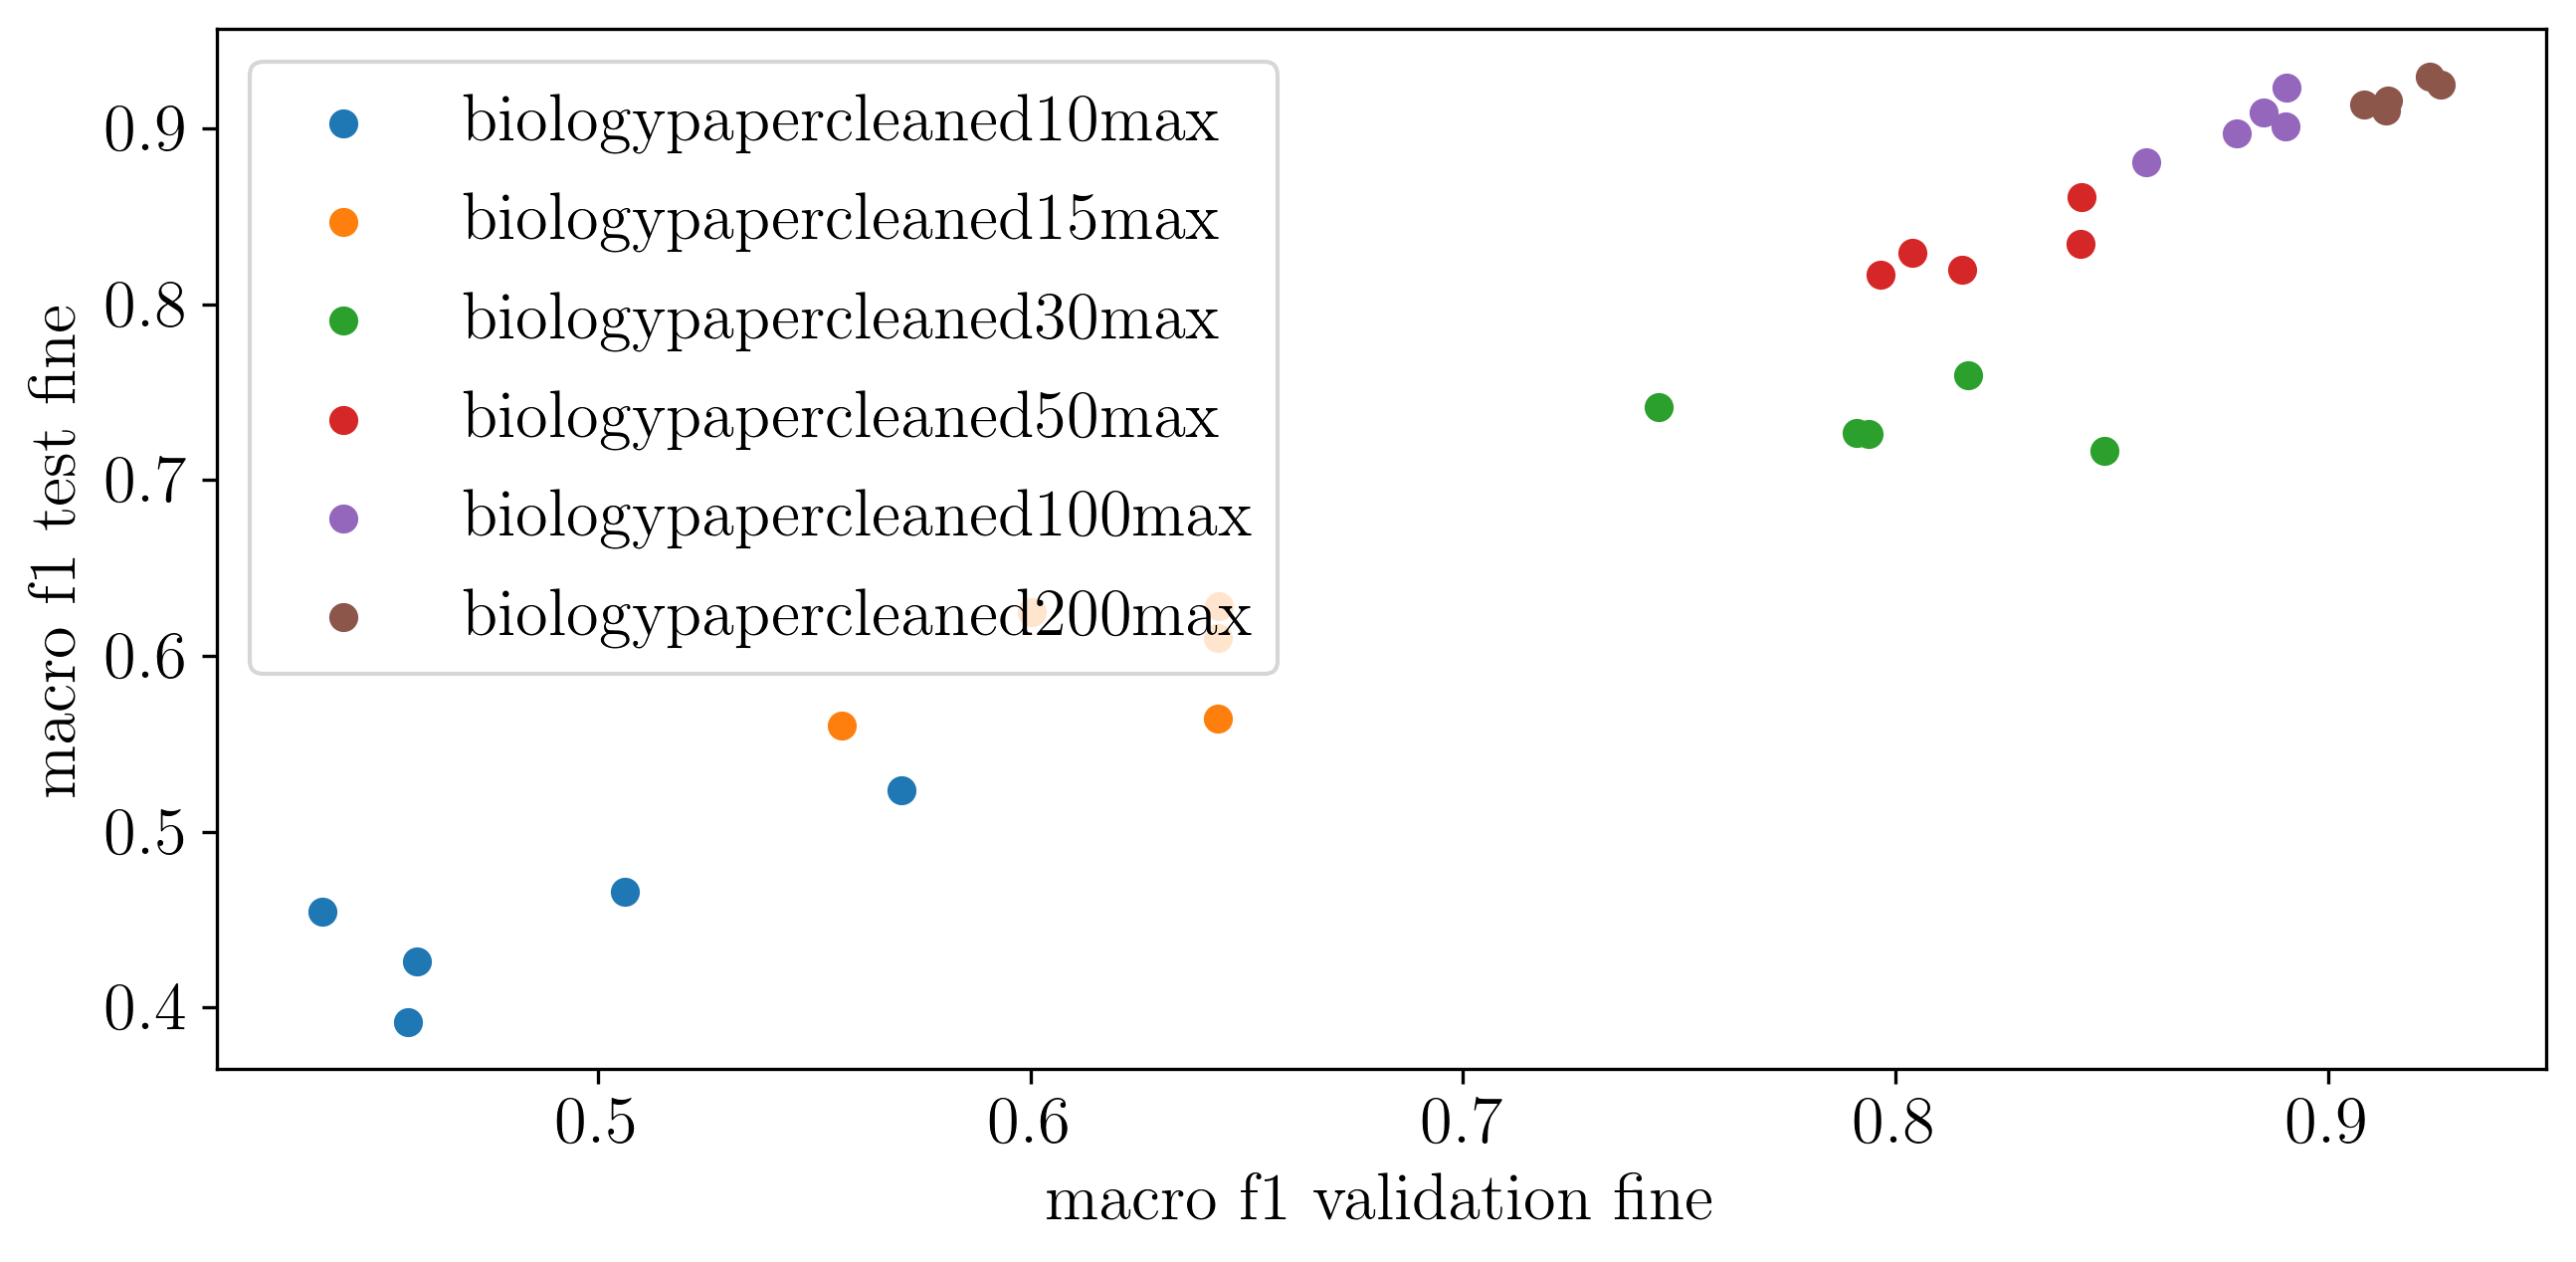

In [7]:
ts.df = ts.df.copy().replace(r"_", "", regex=True)
ts.trialScatter('macro f1 validation fine', 'macro f1 test fine', aggregatedBy='suffix', save_plot=True)

Print scatter plot

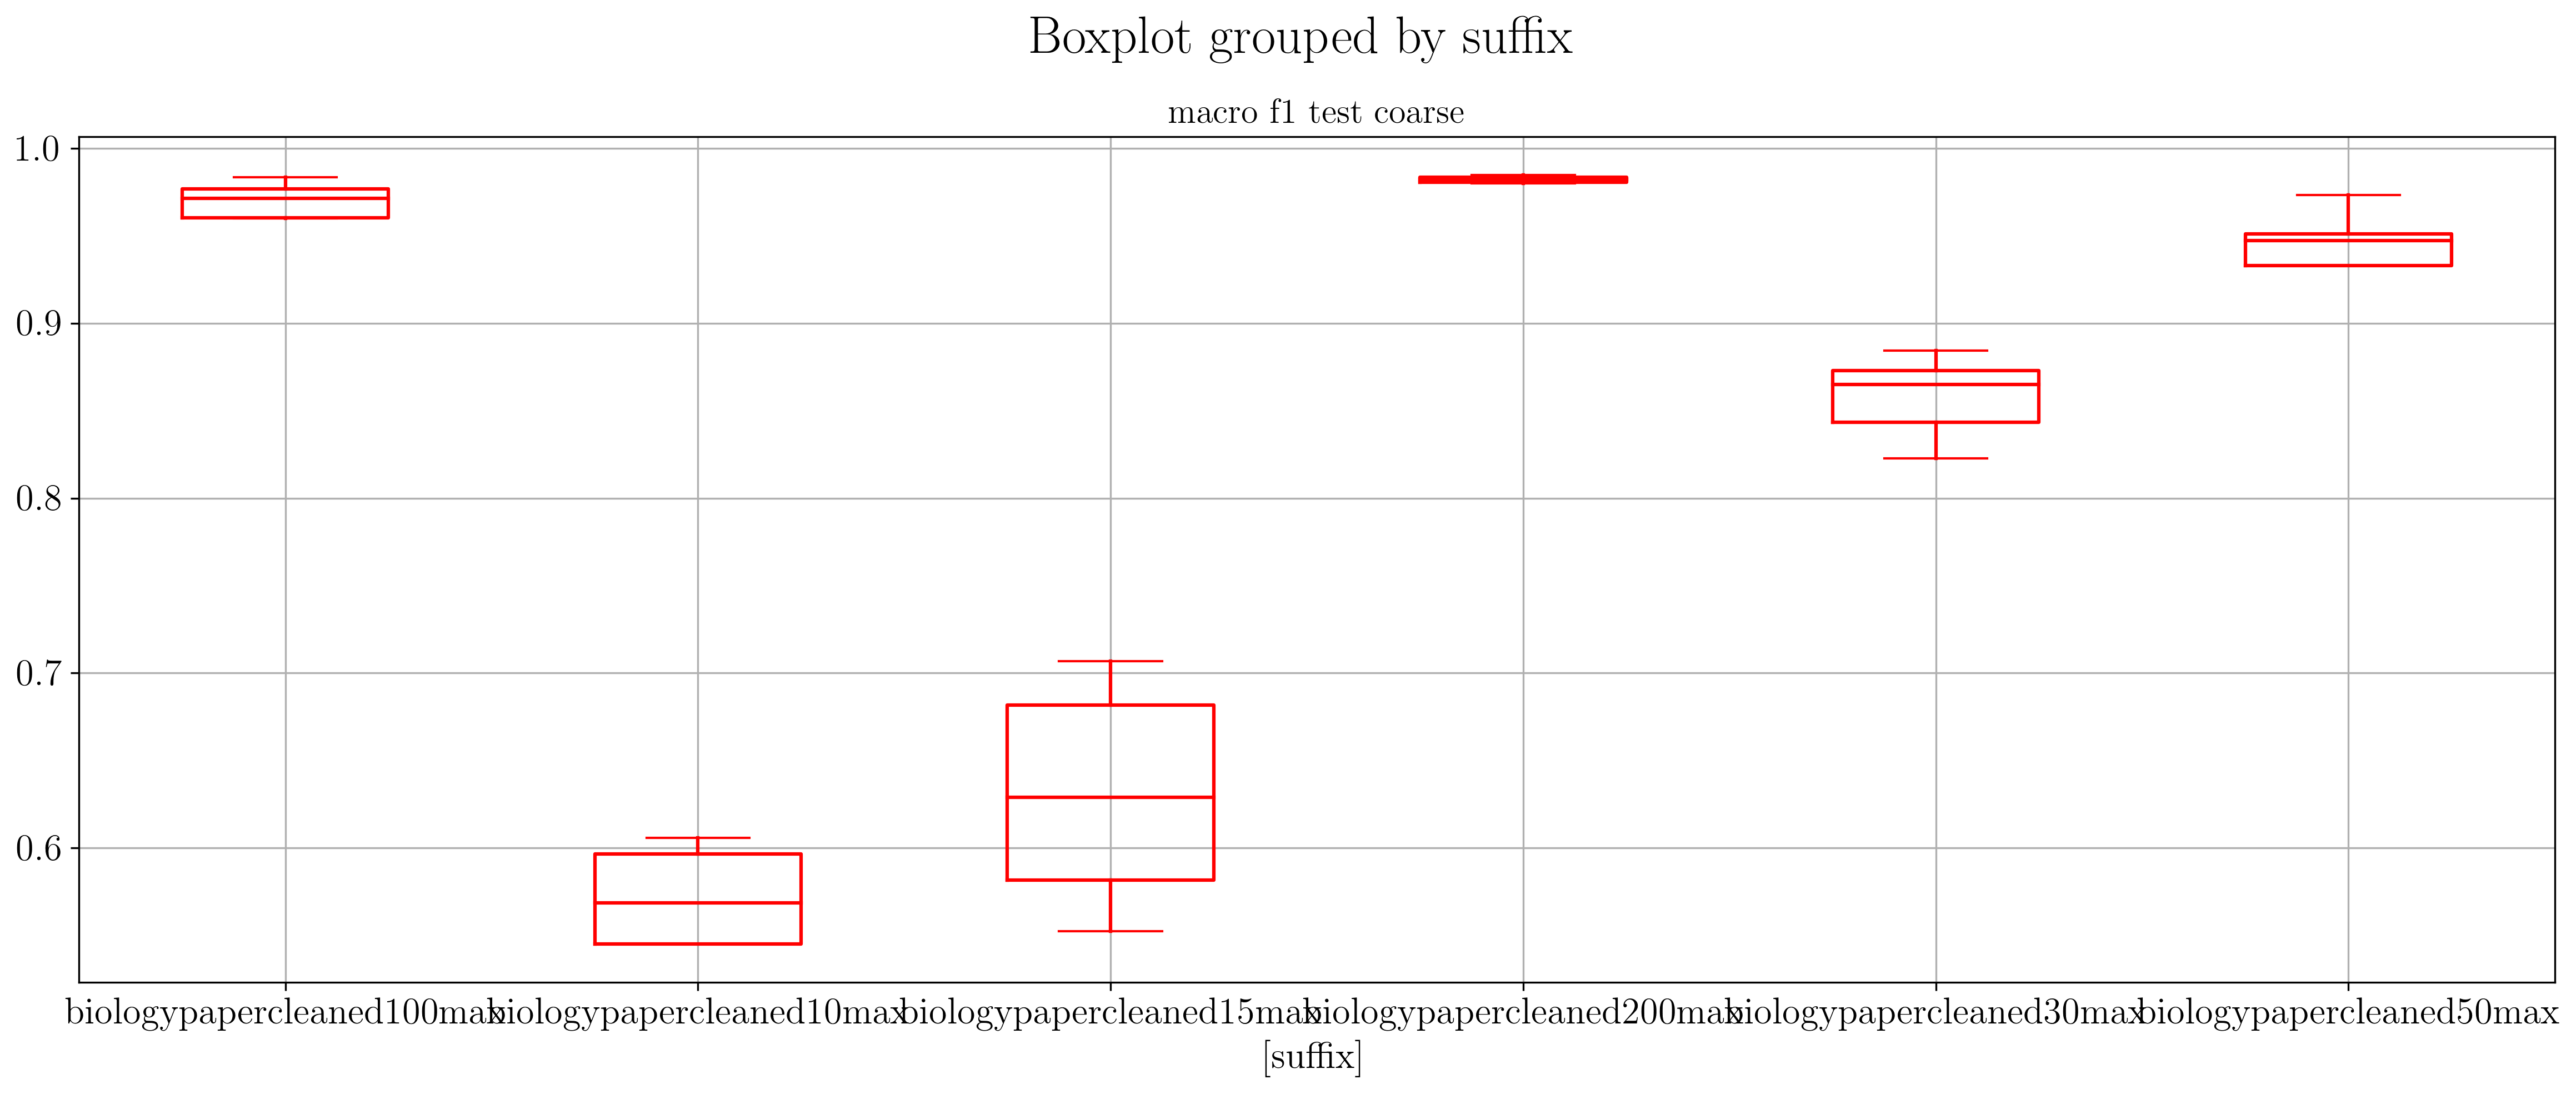

In [8]:
ts.pandasBoxplot(['macro f1 test coarse'], ['suffix'])

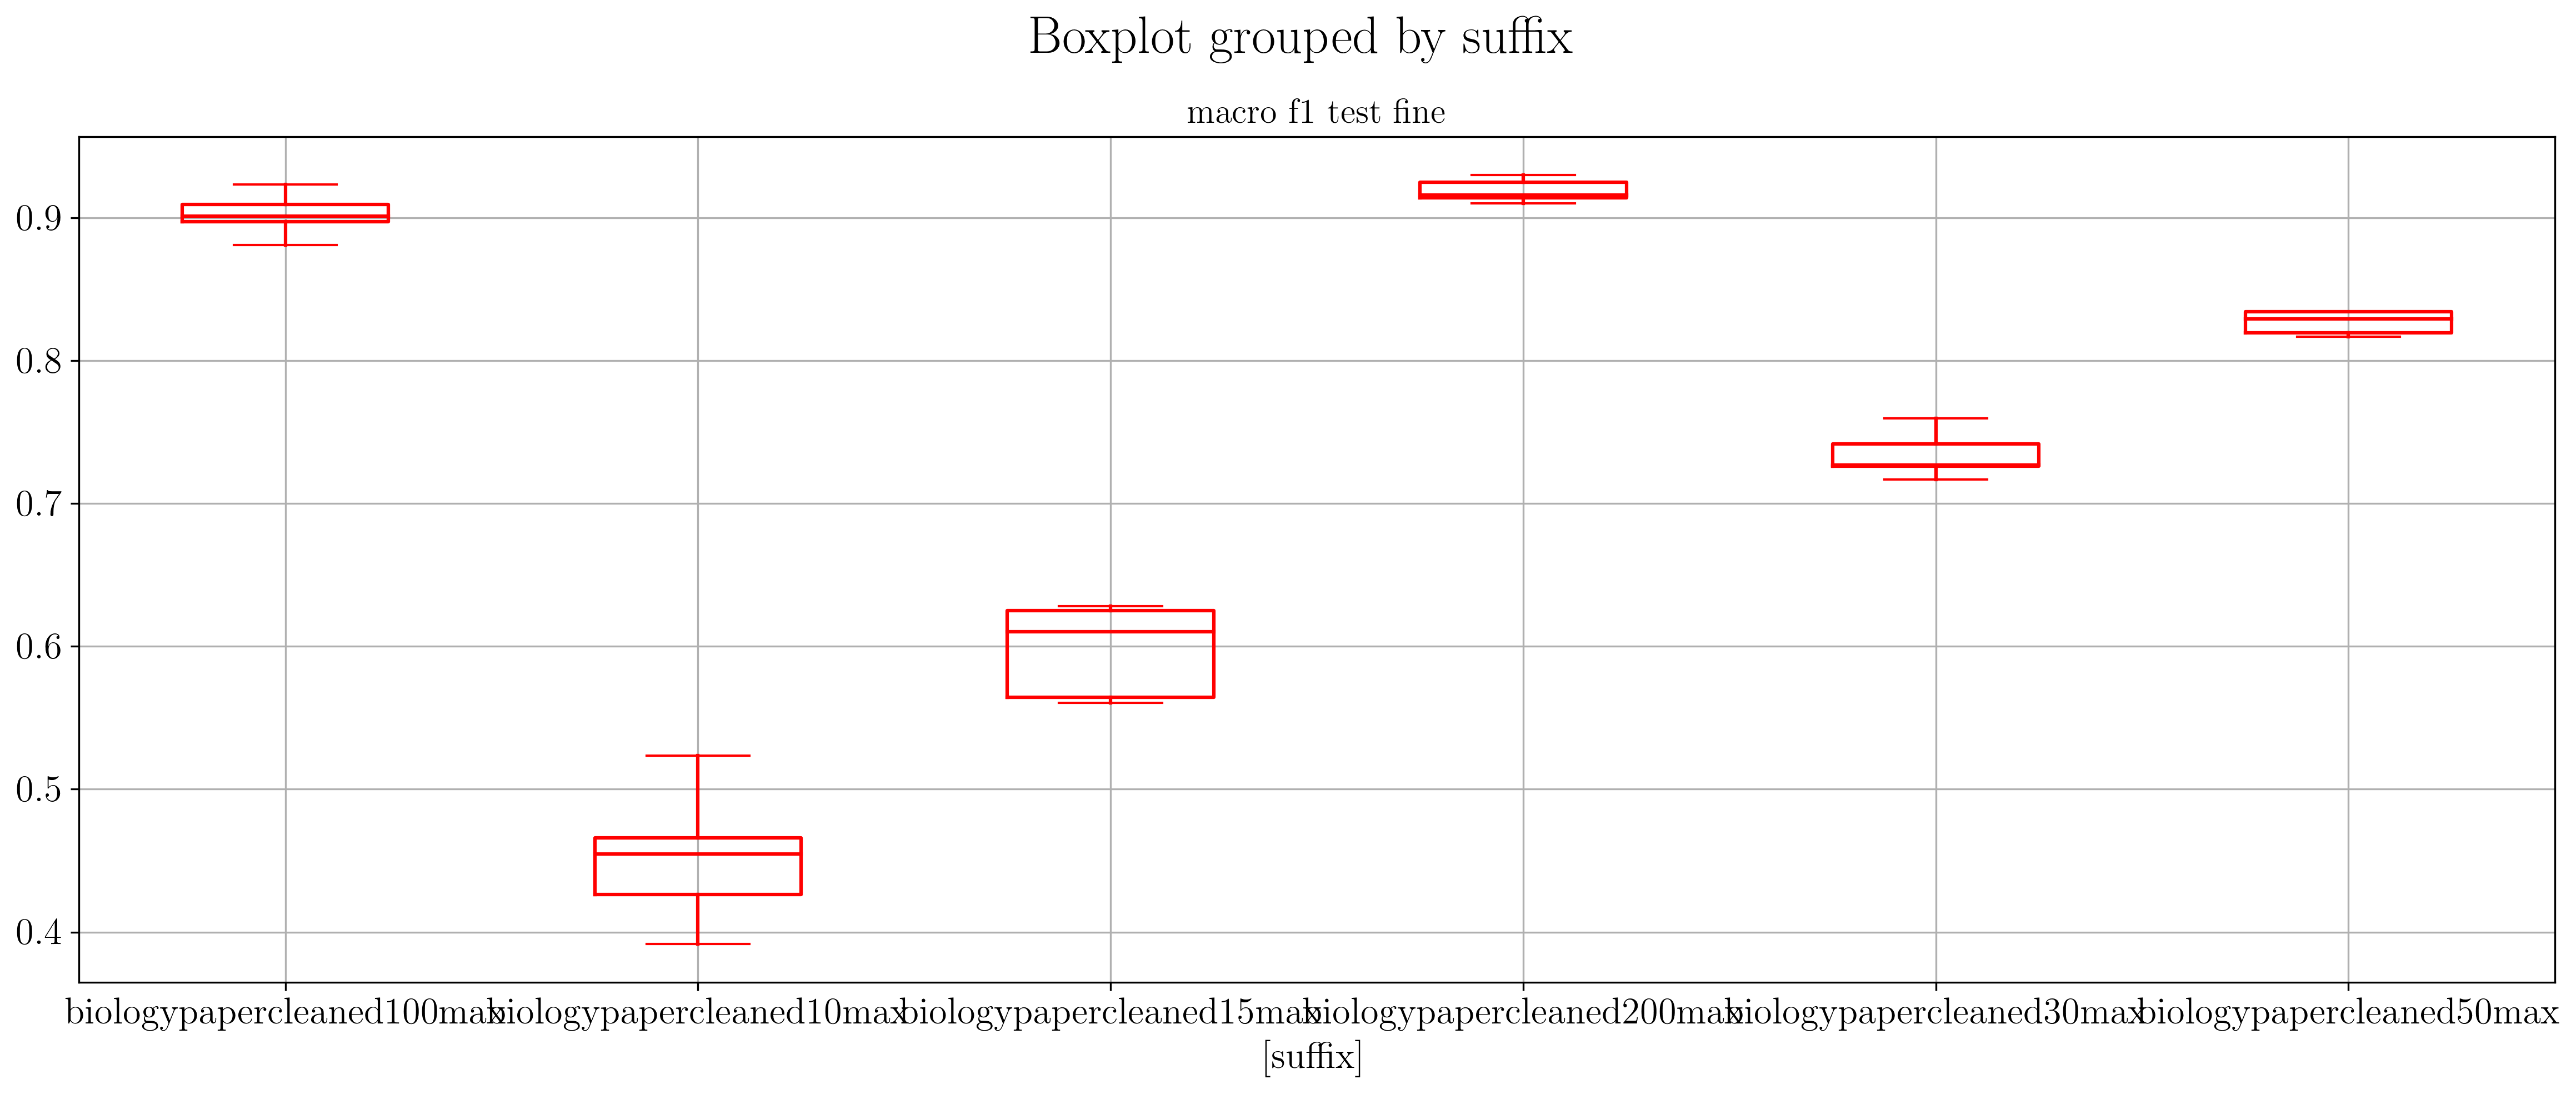

In [9]:
ts.pandasBoxplot(['macro f1 test fine'], ['suffix'])

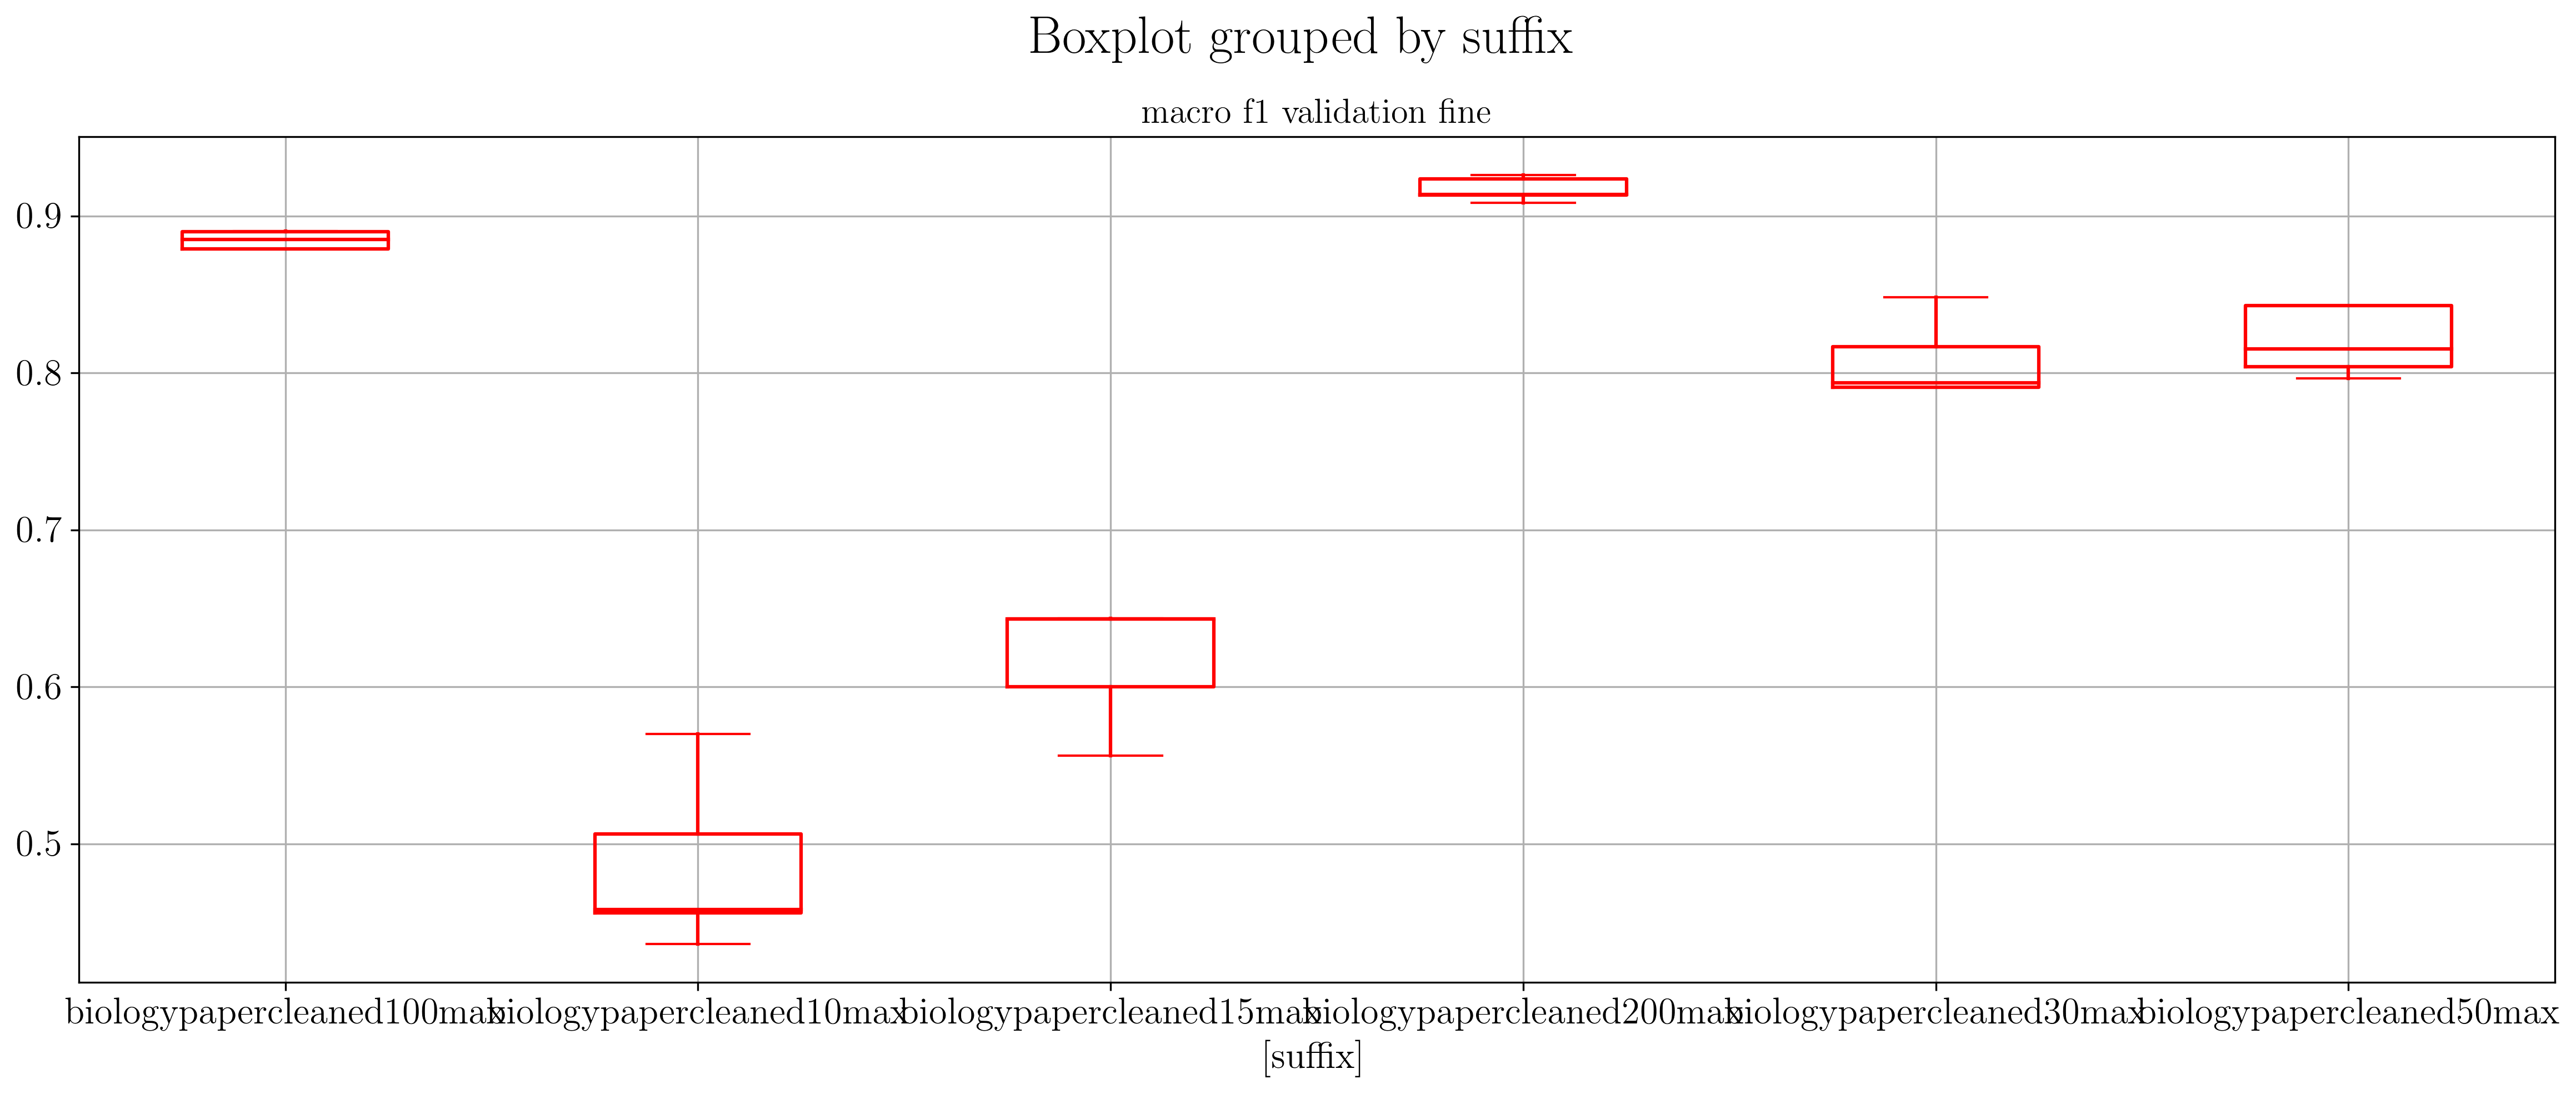

In [10]:
ts.pandasBoxplot(['macro f1 validation fine'], ['suffix'])

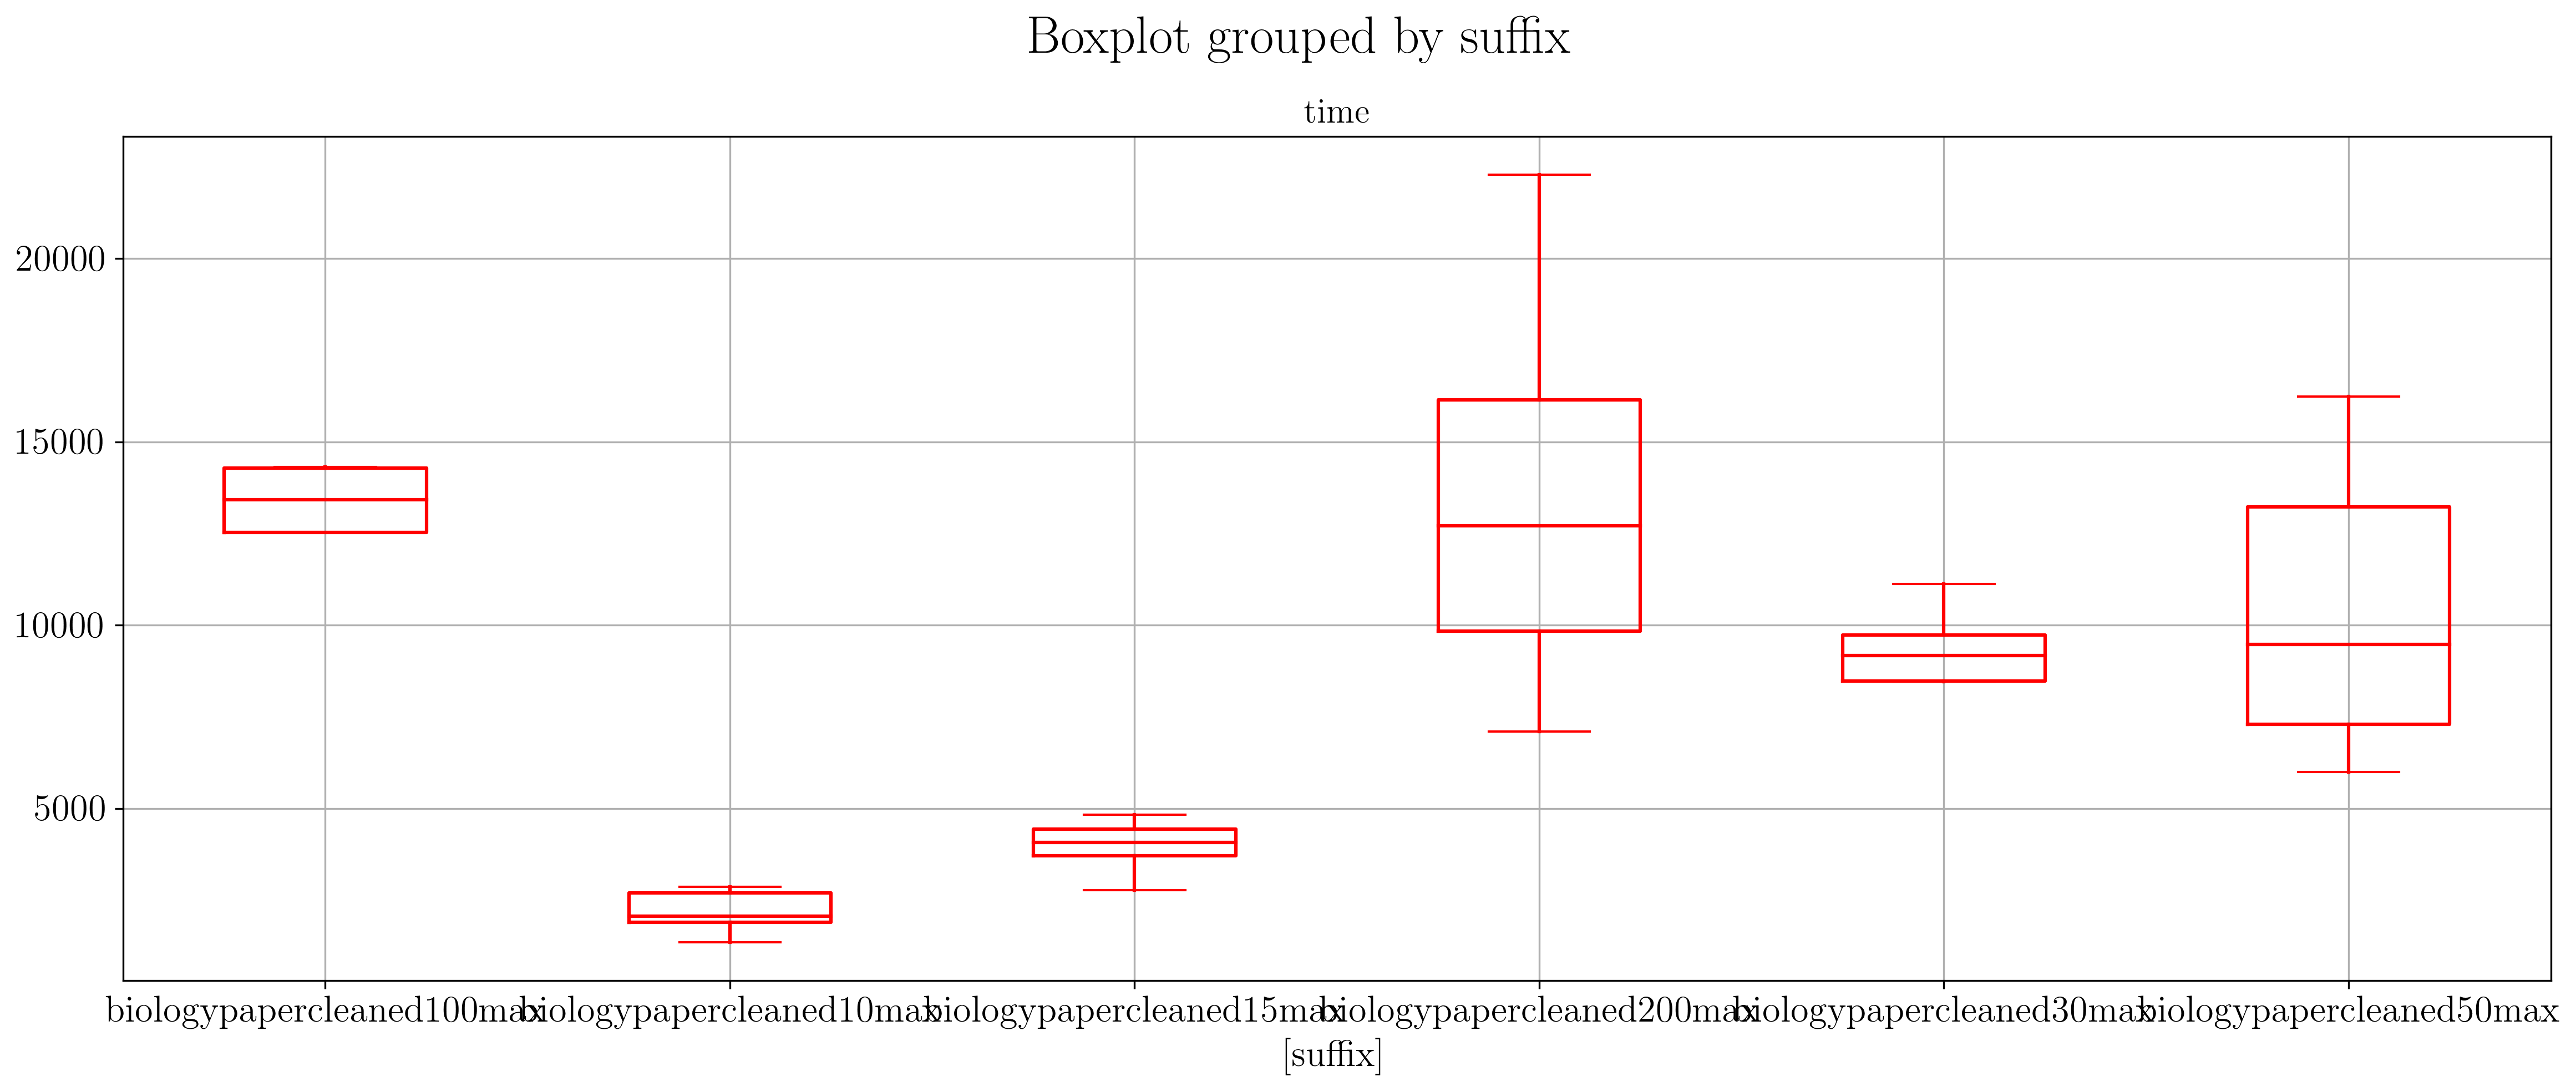

In [11]:
ts.pandasBoxplot(['time'], ['suffix'])

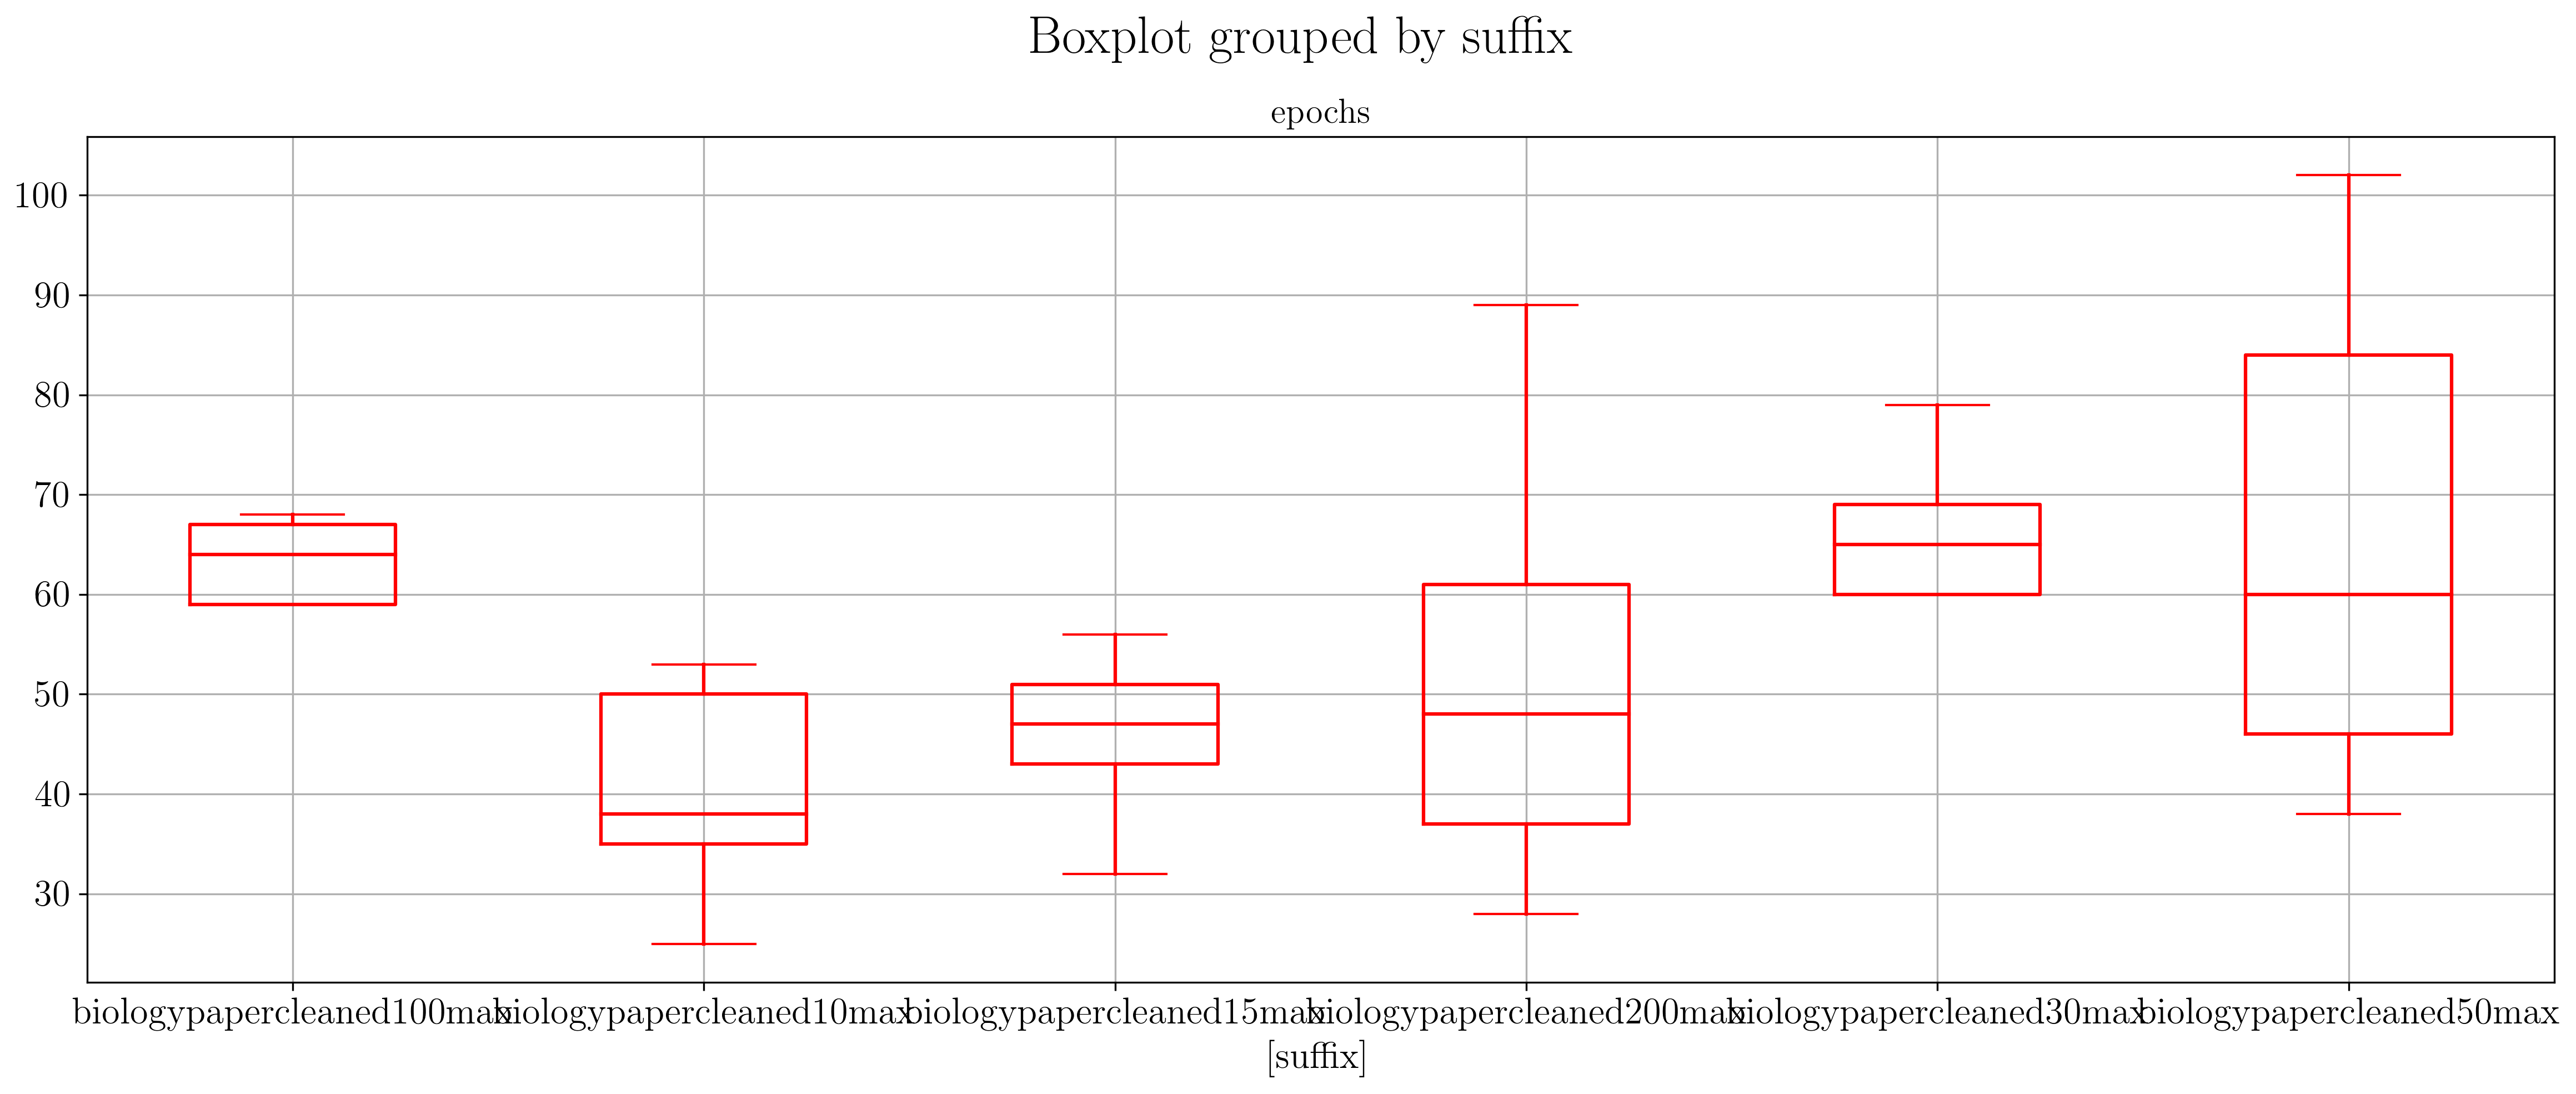

In [12]:
ts.pandasBoxplot(['epochs'], ['suffix'])